# Wine project pre-processing

In [1]:
import pandas as pd
import requests
import json
import numpy as np
import datetime
import time
import tweepy
import re
import seaborn as sns
from statistics import mean
import pycountry as pc
import altair as alt

from datetime import datetime, timedelta

alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [2]:
df = pd.read_csv('..\Data\winemag-data-130k-v2.csv', index_col=0)

## Extract information from title

In [ ]:
titles = df[['title']].values.tolist()
titles = [item for sublist in titles for item in sublist]
titles

In [ ]:
producer = []
years = []
vineyard_grape = []
region = []

for title in titles:
    #print(title)
    result = re.match(r'(\w.+) (\d*) ([^(]+) (\(.*\))', title)
    if result:
        #print(result.groups())
        producer.append(result.group(1))
        years.append(result.group(2))
        vineyard_grape.append(result.group(3))
        region.append(result.group(4)[1:-1])
    else:
        producer.append(0)
        years.append(0)
        vineyard_grape.append(0)
        region.append(0)

df['producer'] = producer
df['year'] = years
df['vineyard_grape'] = vineyard_grape
df['region_from_name'] = region

In [ ]:
df

In [ ]:
sns.histplot(
    data=df.isna().melt(value_name="NaN"),
    y="variable",
    hue="NaN",
    multiple="fill"
)

## Get number of followers of the rating person

In [ ]:
df['taster_twitter_handle']

In [ ]:
# Enter your Twitter API credentials
bearer_token = "AAAAAAAAAAAAAAAAAAAAAPb4lQEAAAAAWvSoI7rh96mCKeQDRBwJzrTTk1U%3DpA4OGY28SYCZ4Jg9iXSqTsNgqtwCQzO86w0tUpSaJsJfiKHikN"

In [ ]:
def getFollowerCount(handle):
    client = tweepy.Client(bearer_token)

    # Get the follower count of a Twitter handle
    user_ids = [handle]
    response = client.get_users(usernames=user_ids, user_fields=["public_metrics"])    

    if (response.data):
        for user in response.data:
            return user.public_metrics['followers_count']
    else:
        print('Not found: ' + handle)
        return 0

In [ ]:
handles = df[['taster_twitter_handle']].values.tolist()
handles

In [ ]:
dict = {}
followers = []

for handle in handles:
    value = handle[0]
    #print(value)

    try:
        result = re.match(r'@(\w+)', value)
    except:
        print('error during parsing')
        followers.append(pd.NA)
        continue;

    if result:
        correct_handle = result.group(1)
        #print(correct_handle)
        if (correct_handle in dict):
            follower_count = dict[correct_handle]
            followers.append(follower_count)
        else:
            follower_count = getFollowerCount(correct_handle)
            dict[correct_handle] = follower_count
            followers.append(follower_count)

df['followers'] = followers

In [ ]:
df

In [ ]:
sns.histplot(
    data=df.isna().melt(value_name="NaN"),
    y="variable",
    hue="NaN",
    multiple="fill"
)

In [ ]:
df.info()

In [ ]:
df.to_csv('..\Data\winemag-data-130k-v2+extract.csv', sep=';')

## Get weather information

Die klimatischen Minimalanforderungen für den Weinbau liegen bei einer mittleren Jahrestemperatur von mindestens 9 Grad Celsius, einer Durchschnittstemperatur des wärmsten Monats von mindestens 18 Grad Celsius, einer maximalen Tiefsttemperatur im Winter von minus 13 Grad Celsius, mindestens 1.300 Sonnenstunden pro Jahr, einer jährlichen Niederschlagsmenge von mindestens 500 mm (in warmem Klima mindestens 750 mm) sowie einer Vegetationsperiode (der Zeit zwischen dem letzten und dem ersten Frost) von mindestens 180 Tagen. Die optimale Temperatur für das Traubenwachstum beträgt zwischen 25 und 28 Grad Celsius. Die Temperatur hängt maßgeblich davon ab, in welcher Höhe die Reben stehen; als Faustregel gilt, dass die Temperatur pro 100 Meter Höhenunterschied aufwärts um 0,6 Grad sinkt.

In [3]:
apikey = '02a31fd84c7c21a1119ad4a77fe43e6f'

In [4]:
df = pd.read_csv('..\Data\winemag-data-130k-v2+extract.csv', index_col=0, delimiter=';')

In [4]:
df = df[['country', 'province', 'region_1']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   country   129908 non-null  object
 1   province  129908 non-null  object
 2   region_1  108724 non-null  object
dtypes: object(3)
memory usage: 4.0+ MB


In [6]:
df

,country,province,region_1
0,Italy,Sicily & Sardinia,Etna
1,Portugal,Douro,NaN
2,US,Oregon,Willamette Valley
3,US,Michigan,Lake Michigan Shore
4,US,Oregon,Willamette Valley
...,...,...,...
129966,Germany,Mosel,NaN
129967,US,Oregon,Oregon
129968,France,Alsace,Alsace
129969,France,Alsace,Alsace


In [7]:
def getGeo(url):
    response = requests.get(url)
    data_str = response.json()
    if (response.status_code != 200):
        print(data_str)
        return pd.NA, pd.NA
    elif (len(data_str) > 0):
        for entry in data_str:
            return entry['lat'], entry['lon']
    else:
        return pd.NA, pd.NA

In [5]:
def getTemp(url):
    response = requests.get(url)
    data_str = response.json()
    if (response.status_code != 200):
        #print(data_str)
        return pd.NA, pd.NA, pd.NA
    elif (len(data_str) > 0):
        return (data_str['result']['temp']['median'] - 273.15), (data_str['result']['humidity']['median']), (data_str['result']['wind']['median'])
    else:
        return pd.NA, pd.NA, pd.NA

In [3]:
pc.countries.search_fuzzy('Italy')

[Country(alpha_2='IT', alpha_3='ITA', flag='🇮🇹', name='Italy', numeric='380', official_name='Italian Republic')]

In [8]:
dict = {}
lats = []
lons = []

for index, row in df.iterrows():
    country = row['country']
    province = row['province']
    region = row['region_1']
    
    if (country == 'England'):
        country = 'United Kingdom'
    
    try:
        countryIso = pc.countries.search_fuzzy(country)
    except:
        print('No country for: ' + str(country))
        lats.append(pd.NA)
        lons.append(pd.NA)
        continue
    
    url = "http://pro.openweathermap.org/geo/1.0/direct?q="
    if (pd.isna(province) is False):
        url += str(province) + ","

    if (pd.isna(country) is False):
        url += str(countryIso[0].alpha_2)

    url += "&limit=1&appid=" + apikey

    if (index % 1000 == 0):
        print(index)
    
    if (url in dict):
        lat, lon = dict[url]
        #print('got from dict:' + str(lat) + "," + str(lon))
    else:
        lat, lon = getGeo(url)
        dict[url] = (lat, lon)
        #print('got from url:' + str(lat) + "," + str(lon))
    
    lats.append(lat)
    lons.append(lon)

df['lat'] = lats
df['lon'] = lons

0
No country for: nan
1000
2000
3000
No country for: nan
4000
No country for: nan
5000
6000
7000
8000
9000
No country for: nan
No country for: nan
10000
11000
No country for: nan
No country for: nan
12000
13000
14000
No country for: nan
15000
No country for: nan
No country for: nan
17000
18000
No country for: nan
19000
20000
21000
22000
23000
24000
25000
26000
No country for: nan
No country for: nan
No country for: nan
27000
No country for: nan
28000
29000
30000
31000
32000
33000
34000
35000
36000
No country for: nan
37000
38000
No country for: nan
No country for: nan
39000
40000
41000
42000
43000
44000
No country for: nan
No country for: nan
No country for: nan
45000
No country for: nan
No country for: nan
46000
No country for: nan
47000
48000
49000
No country for: nan
No country for: nan
No country for: nan
No country for: nan
50000
51000
52000
53000
54000
No country for: nan
55000
56000
57000
No country for: nan
58000
59000
No country for: nan
60000
No country for: nan
61000
62000
6

In [9]:
df_dict = df.from_dict(dict).T

In [10]:
with open("geo.json", "w") as write_file:
    json.dump(df_dict.to_json(), write_file, indent=4)

<AxesSubplot: xlabel='Count', ylabel='variable'>

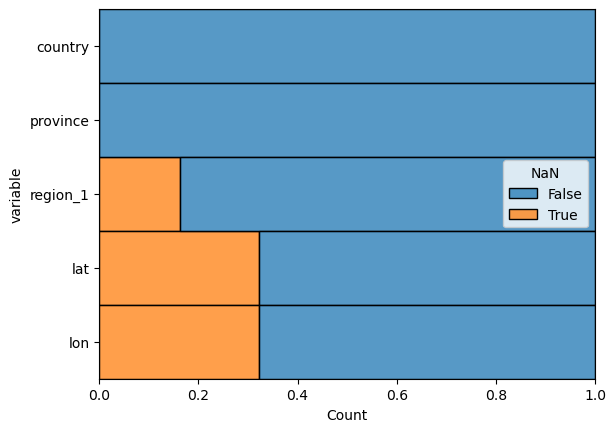

In [11]:
sns.histplot(
    data=df.isna().melt(value_name="NaN"),
    y="variable",
    hue="NaN",
    multiple="fill"
)

In [ ]:
df

In [ ]:
print(alt.__version__)

In [ ]:
alt.Chart(df).mark_circle().encode(
    longitude='lon:Q',
    latitude='lat:Q',
    size=alt.value(10),
    tooltip='name'
).properties(
    width=500,
    height=400
)

In [ ]:
df.isna().sum()

In [ ]:
df.info()

In [ ]:
df.to_csv('..\Data\winemag-data-130k-v2+geo.csv', sep=';')

## Weather data

In [8]:
apikey = '02a31fd84c7c21a1119ad4a77fe43e6f'

In [9]:
df = pd.read_csv('..\Data\winemag-data-130k-v2+geo.csv', index_col=0, delimiter=';')

In [10]:
df = df[7000:14000]
df

,country,province,region_1,lat,lon
7000,Italy,Piedmont,Langhe,NaN,NaN
7001,France,Alsace,Alsace,48.684873,2.175608
7002,France,Provence,Palette,46.097449,4.580808
7003,France,Provence,Coteaux d'Aix-en-Provence,46.097449,4.580808
7004,France,Bordeaux,Saint-Émilion,44.841225,-0.580036
...,...,...,...,...,...
13995,US,California,Edna Valley,38.628683,-92.565963
13996,Portugal,Dão,NaN,39.937559,-7.863877
13997,Portugal,Dão,NaN,39.937559,-7.863877
13998,France,Alsace,Crémant d'Alsace,48.684873,2.175608


In [11]:
dict = {}
temps = []
tempMin = []
tempMax = []
humidities = []
winds = []
location = []

for index, row in df.iterrows():
    lat = row['lat']
    lon = row['lon']

    if (pd.isna(lat) and pd.isna(lon)):
        temps.append(pd.NA)
        tempMin.append(pd.NA)
        tempMax.append(pd.NA)
        humidities.append(pd.NA)
        winds.append(pd.NA)
        location.append(pd.NA)
        continue

    # check if location is in north or south of the earth
    monthRange = [4,5,6,7,8,9,10]
    if (lat >= 0):
        location.append(1)
    else:
        monthRange = [10,11,12,1,2,3,4]
        location.append(0)

    # with our subscription we can only get data from last year.
    tempList = []
    humidityList = []
    windList = []
    for month in monthRange:
        url = "https://history.openweathermap.org/data/2.5/aggregated/month?lat="+str(round(lat, 2))+"&lon="+str(round(lon, 2))+"&month=" + str(month) + "&units=metric&appid=" + apikey
    
        if (url in dict):
            temp, humidity, wind = dict[url]
            #print('got from dict:' + str(lat) + "," + str(lon))
        else:
            temp, humidity, wind = getTemp(url)
            dict[url] = (temp, humidity, wind)
            #print('got from url:' + str(lat) + "," + str(lon))
        
        tempList.append(temp)
        humidityList.append(humidity)
        windList.append(wind)

    temps.append(mean(tempList))
    tempMin.append(min(tempList))
    tempMax.append(max(tempList))
    humidities.append(mean(humidityList))
    winds.append(mean(windList))

df['temp'] = temps
df['tempMin'] = tempMin
df['tempMax'] = tempMax
df['humidity'] = humidities
df['wind'] = winds
df['location'] = location
df

,country,province,region_1,lat,lon,temp,tempMin,tempMax,humidity,wind,location
7000,Italy,Piedmont,Langhe,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
7001,France,Alsace,Alsace,48.684873,2.175608,16.068571,11.0,20.53,72.285714,3.107143,1
7002,France,Provence,Palette,46.097449,4.580808,17.095714,11.53,22.0,63.285714,2.688571,1
7003,France,Provence,Coteaux d'Aix-en-Provence,46.097449,4.580808,17.095714,11.53,22.0,63.285714,2.688571,1
7004,France,Bordeaux,Saint-Émilion,44.841225,-0.580036,18.041429,13.0,22.0,70.714286,2.842857,1
...,...,...,...,...,...,...,...,...,...,...,...
13995,US,California,Edna Valley,38.628683,-92.565963,20.167143,12.97,25.26,71.428571,3.212857,1
13996,Portugal,Dão,NaN,39.937559,-7.863877,17.398571,13.5,19.97,80.142857,1.681429,1
13997,Portugal,Dão,NaN,39.937559,-7.863877,17.398571,13.5,19.97,80.142857,1.681429,1
13998,France,Alsace,Crémant d'Alsace,48.684873,2.175608,16.068571,11.0,20.53,72.285714,3.107143,1


In [12]:
df.to_csv('..\Data\winemag-data-130k-v2+temp_7000-14000.csv', sep=';')

In [ ]:
#df = df = pd.read_csv('..\Data\winemag-data-130k-v2+geo.csv', index_col=0, delimiter=';')
#df

## Extract attributes from description

In [ ]:
df = pd.read_csv('..\Data\winemag-data-130k-v2+extract.csv', index_col=0, delimiter=';')
df_words = pd.read_csv('..\Process\wordlist_output.csv', delimiter=';')

In [ ]:
df_words.sort_values('total', ascending=False, inplace=True)
df_words.reset_index(drop=True, inplace=True)
df_words

In [ ]:
descriptions = df[['description']].values.tolist()

In [ ]:
dict = {}
words = []

for description in descriptions:
    attributes = []
    for word in df_words['word']:
        if word in description[0]:
            attributes.append(word)

    words.append(attributes)

words

In [ ]:
df['desc'] =  [','.join(ele) for ele in words]
df

In [ ]:
df.to_csv('..\Data\winemag-data-130k-v2+extract.csv', sep=';')